# Project Overview: Predicting Bitcoin Trend Direction with Machine Learning

This project aims to predict the *trend direction* of Bitcoin (BTC-USD) using 
daily OHLCV (Open, High, Low, Close, Volume) data and engineered technical
indicators. The prediction target is defined by a trend-following rule:

**Signal = 1 if MA10 ≥ MA60 else 0**

Where MA10 and MA60 are the 10-day and 60-day moving averages.

## Motivation

Trend-following is one of the most common trading strategies in quantitative
finance. Machine learning enhances trend-following by:

- Combining multiple indicators (momentum, volatility, volume)
- Learning nonlinear relationships (via XGBoost)
- Reducing false signals from noisy market conditions
- Automating the recognition of emerging trends

Predicting market direction is valuable for:

- Portfolio timing  
- Risk management  
- Algorithmic trading systems  
- Enhancing trend-following strategies  

This notebook demonstrates a full ML workflow:  
**Data → Features → Modeling → Evaluation → Backtest**  
using clean, reproducible methods aligned with best practices in quantitative analytics.


In [45]:
# BTC Price Prediction Notebook

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import ta

from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import joblib

plt.style.use("seaborn-v0_8-darkgrid")

DATA_PATH = "data"
os.makedirs(DATA_PATH, exist_ok=True)

START = "2019-01-01"
END   = "2025-01-01"
TRAIN_RATIO = 0.8

In [46]:
# Downloading raw BTC data

def download_btc(start=START, end=END, save_path='data/raw_btc.csv'):
    os.makedirs('data', exist_ok=True)
    df = yf.download('BTC-USD', start=start, end=end, progress=False)
    df.to_csv(save_path)
    return df

# Load or download data with MultiIndex headers
csv_path = "data/raw_btc.csv"

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path, header=[0,1,2], index_col=0, parse_dates=True)
else:
    download_btc()
    df = pd.read_csv(csv_path, header=[0,1,2], index_col=0, parse_dates=True)

# Flatten MultiIndex → match screenshot structure
df.columns = ["Close", "High", "Low", "Open", "Volume"]

# Save cleaned version
df.to_csv(csv_path)

print("Data range:", df.index.min(), "to", df.index.max())
df.head()


Data range: 2019-01-03 00:00:00 to 2024-12-31 00:00:00


,Close,High,Low,Open,Volume
2019-01-03,3836.741211,3935.685059,3826.222900,3931.048584,4530215219
2019-01-04,3857.717529,3865.934570,3783.853760,3832.040039,4847965467
2019-01-05,3845.194580,3904.903076,3836.900146,3851.973877,5137609824
2019-01-06,4076.632568,4093.297363,3826.513184,3836.519043,5597027440
2019-01-07,4025.248291,4092.613525,4020.894043,4078.584961,5228625637


##  Data Loading & Cleaning

Yahoo Finance provides BTC-USD historical data with the following fields:

- **Open**: Opening price  
- **High**: Highest price of the day  
- **Low**: Lowest price of the day  
- **Close**: Closing price  
- **Volume**: Total traded volume  

These columns are sufficient for generating most technical indicators.  
During preprocessing, column names were cleaned to ensure consistency
and unnecessary MultiIndex formatting was removed.

After cleaning, the final dataset contains:


In [47]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2190 entries, 2019-01-03 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2190 non-null   float64
 1   High    2190 non-null   float64
 2   Low     2190 non-null   float64
 3   Open    2190 non-null   float64
 4   Volume  2190 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 102.7 KB


,Close,High,Low,Open,Volume
2019-01-03,3836.741211,3935.685059,3826.222900,3931.048584,4530215219
2019-01-04,3857.717529,3865.934570,3783.853760,3832.040039,4847965467
2019-01-05,3845.194580,3904.903076,3836.900146,3851.973877,5137609824
2019-01-06,4076.632568,4093.297363,3826.513184,3836.519043,5597027440
2019-01-07,4025.248291,4092.613525,4020.894043,4078.584961,5228625637


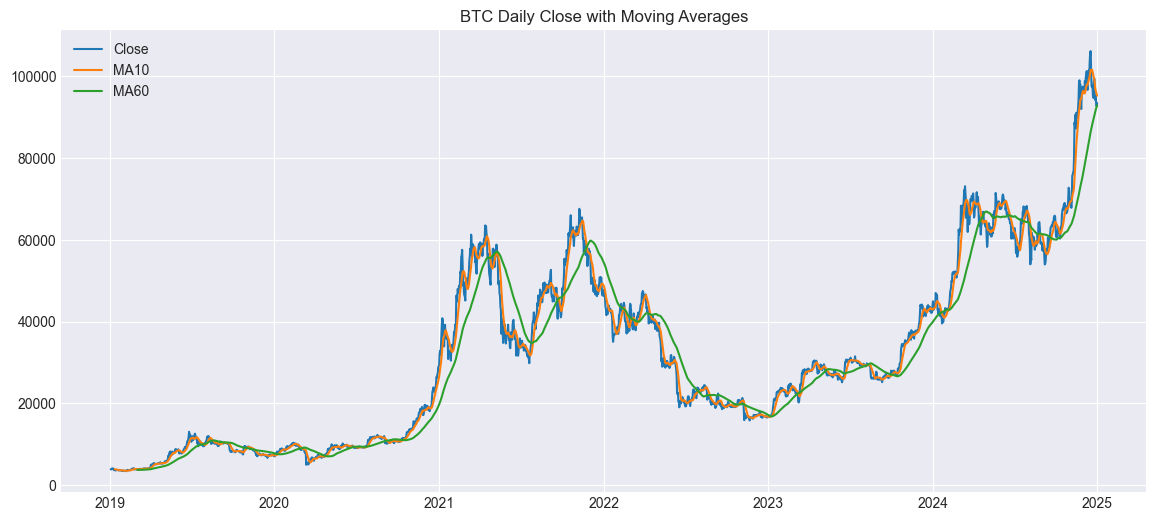

In [48]:
# Price and Moving Averages Visualization

plt.figure(figsize=(14,6))
plt.plot(df.index, df["Close"], label="Close")
plt.plot(df["Close"].rolling(10).mean(), label="MA10")
plt.plot(df["Close"].rolling(60).mean(), label="MA60")
plt.title("BTC Daily Close with Moving Averages")
plt.legend()
plt.show()

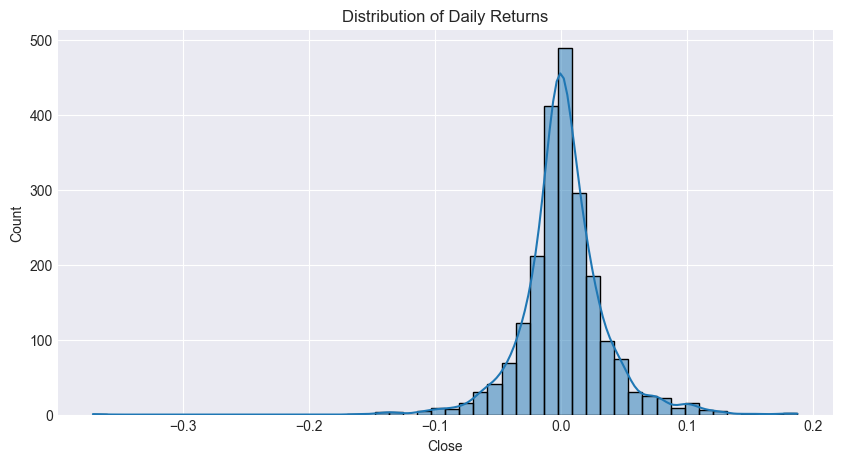

In [49]:
# Distribution of Daily Returns

returns = df["Close"].pct_change().dropna()

plt.figure(figsize=(10,5))
sns.histplot(returns, bins=50, kde=True)
plt.title("Distribution of Daily Returns")
plt.show()

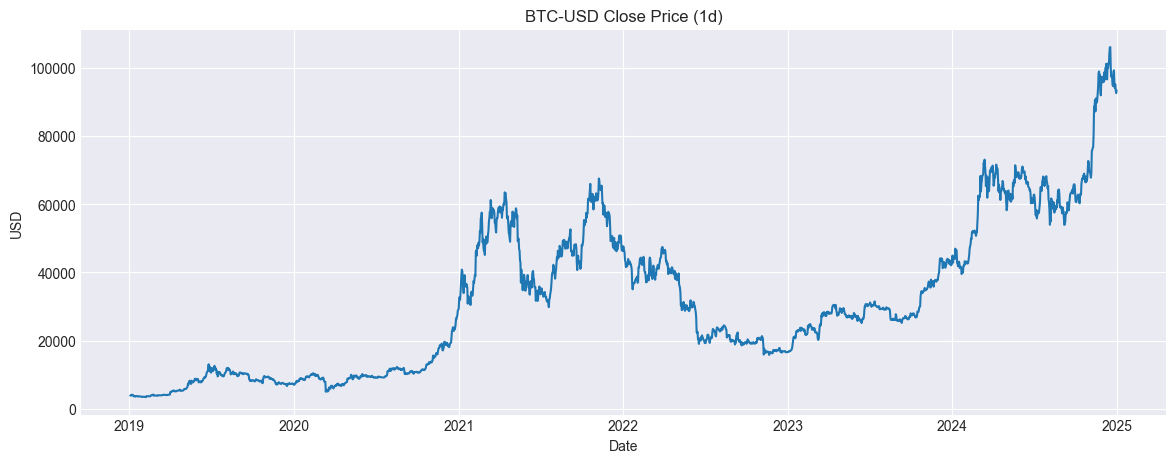

In [50]:
# Plotting Close Price

plt.figure(figsize=(14,5))
plt.plot(df.index, df["Close"])
plt.title("BTC-USD Close Price (1d)")
plt.xlabel("Date")
plt.ylabel("USD")
plt.show()

In [51]:
# Indicator Helper Functions

def compute_rsi(price, window=14):
    delta = price.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.ewm(alpha=1/window, adjust=False).mean()
    ma_down = down.ewm(alpha=1/window, adjust=False).mean()
    rs = ma_up / (ma_down + 1e-9)
    return 100 - (100 / (1 + rs))

In [52]:
# Building Technical Indicators

def create_indicators(df):
    d = df.copy()

    close = d["Close"]
    high  = d["High"]
    low   = d["Low"]
    vol   = d["Volume"]

    # Momentum
    d["rsi_14"] = compute_rsi(close, 14)
    d["rsi_30"] = compute_rsi(close, 30)
    d["roc_9"]  = ta.momentum.roc(close, 9)
    d["mom_30"] = ta.momentum.roc(close, 30)
    macd = ta.trend.MACD(close)
    d["macd"] = macd.macd()

    # Trend
    d["ema_10"]  = ta.trend.ema_indicator(close, 10)
    d["ema_30"]  = ta.trend.ema_indicator(close, 30)
    d["ema_200"] = ta.trend.ema_indicator(close, 200)

    # Stochastic
    for w in [10, 30, 200]:
        st = ta.momentum.StochasticOscillator(high, low, close, w)
        d[f"%k_{w}"] = st.stoch()
        d[f"%d_{w}"] = st.stoch_signal()

    # Volatility
    bb = ta.volatility.BollingerBands(close)
    d["bb_mavg"] = bb.bollinger_mavg()
    d["bb_high"] = bb.bollinger_hband()
    d["bb_low"]  = bb.bollinger_lband()
    d["atr_14"]  = ta.volatility.average_true_range(high, low, close, 14)
    d["cci_20"]  = ta.trend.cci(high, low, close, 20)

    # Volume
    d["cmf_20"] = ta.volume.chaikin_money_flow(high, low, close, vol, 20)
    d["obv"]    = ta.volume.on_balance_volume(close, vol)
    d["adl"]    = ta.volume.acc_dist_index(high, low, close, vol)

    return d.dropna()

df_ind = create_indicators(df)
df_ind.to_csv("data/btc_indicators.csv")

print("Indicators created:", df_ind.shape)
df_ind.head()


Indicators created: (1989, 27)


,Close,High,Low,Open,Volume,rsi_14,rsi_30,roc_9,mom_30,macd,...,%k_200,%d_200,bb_mavg,bb_high,bb_low,atr_14,cci_20,cmf_20,obv,adl
2019-07-23,9900.767578,10346.748047,9883.594727,10346.748047,17851916995,44.451926,50.110049,-3.464206,-8.793836,-94.138087,...,62.560813,66.214908,10978.326611,12619.981651,9336.671572,821.667980,-96.764699,-0.061984,571976667839,4.210594e+11
2019-07-24,9811.925781,9908.796875,9614.306641,9887.730469,17398734322,43.864160,49.774739,-9.941763,-10.890615,-146.342336,...,61.707014,63.693222,10908.151025,12621.681498,9194.620553,784.012427,-110.076761,0.000385,554577933517,4.270117e+11
2019-07-25,9911.841797,10154.253906,9773.957031,9809.096680,15821952090,44.748984,50.162726,4.581311,-15.936633,-177.604873,...,62.667240,62.311689,10854.820117,12621.836723,9087.803512,755.175601,-84.778495,0.022835,570399885607,4.226629e+11
2019-07-26,9870.303711,9916.517578,9717.982422,9913.126953,14495714483,44.435409,49.996625,1.820761,-24.169267,-203.387907,...,62.268045,62.214100,10787.907764,12597.125293,8978.690235,715.415570,-87.345578,0.054813,555904171124,4.304102e+11
2019-07-27,9477.677734,10167.320312,9411.521484,9871.165039,16817809536,41.476840,48.428622,-11.145236,-15.247772,-252.591069,...,58.494779,61.143355,10689.249316,12557.343815,8821.154818,718.300088,-93.666484,-0.000451,539086361588,4.165365e+11


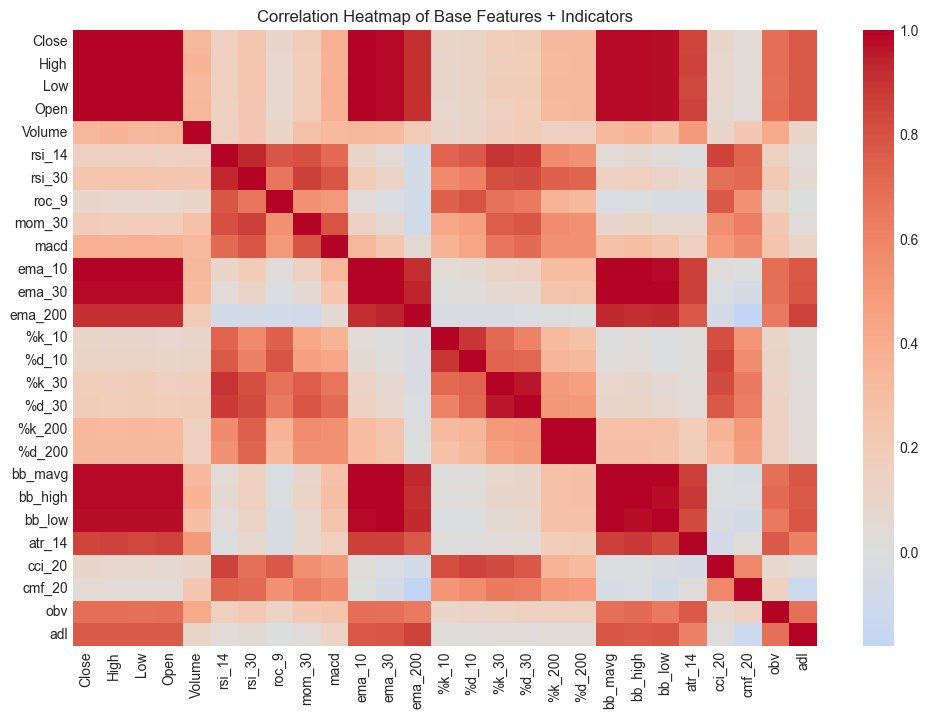

In [53]:
# Correlation Heatmap for Indicators

plt.figure(figsize=(12,8))
sns.heatmap(df_ind.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Base Features + Indicators")
plt.show()

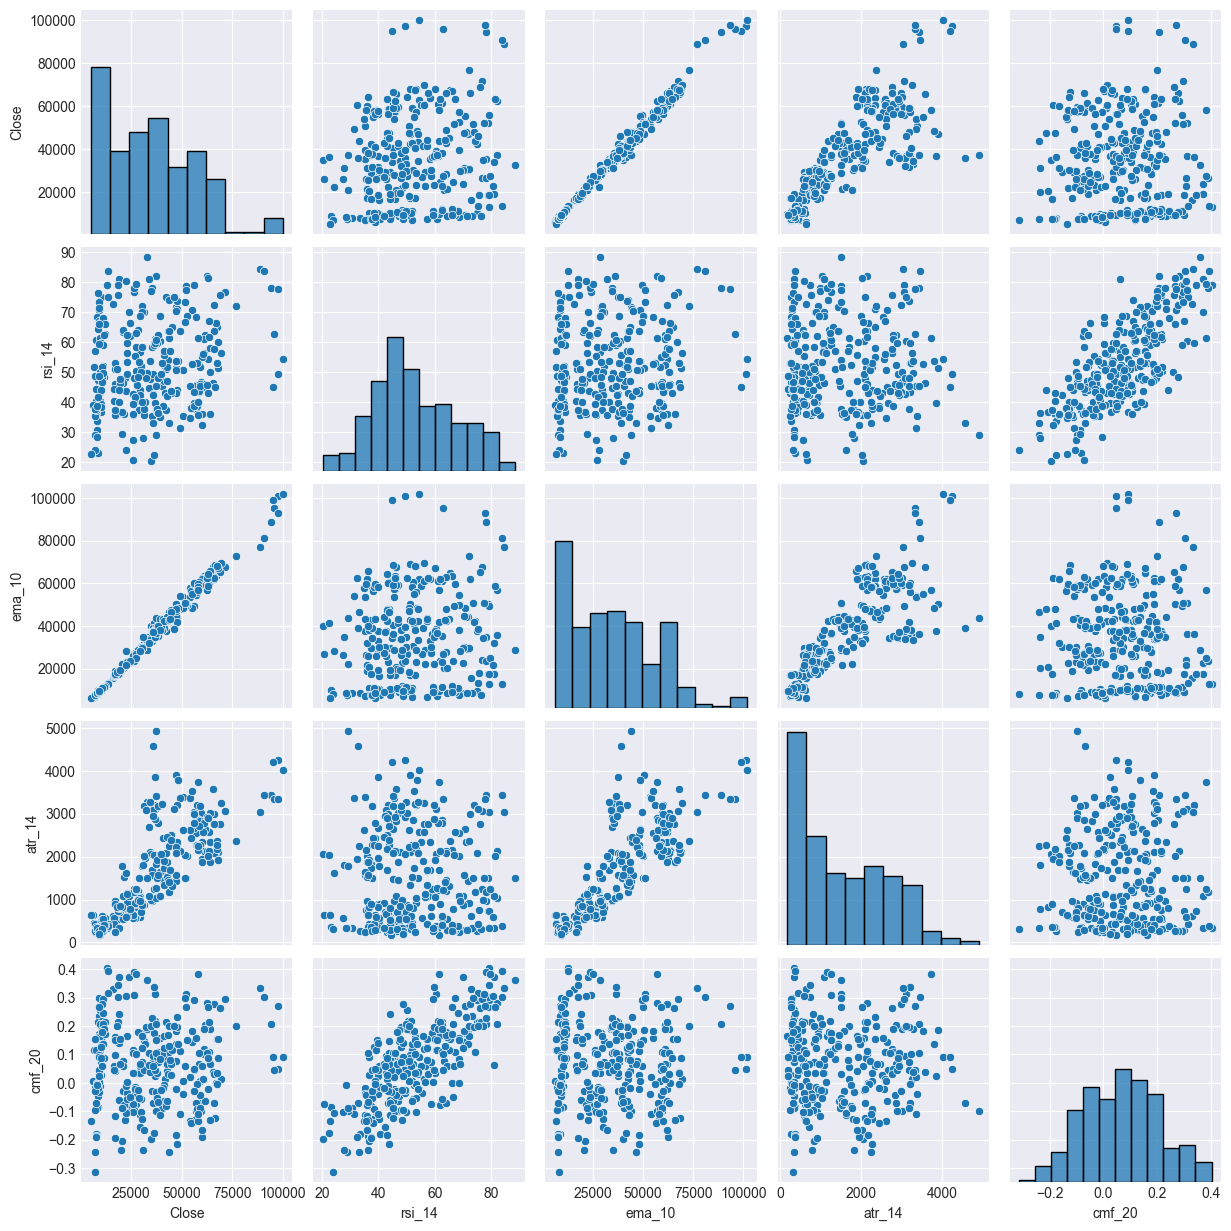

In [54]:
# Feature Pairplot (Small Subset)

sns.pairplot(df_ind[["Close","rsi_14","ema_10","atr_14","cmf_20"]].sample(300))
plt.show()

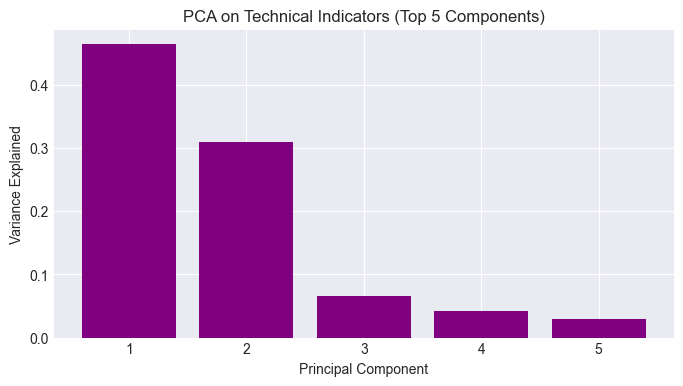

array([0.46365141, 0.30840611, 0.06538352, 0.04198457, 0.02975257])

In [55]:
# PCA on Indicators

from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(df_ind)

pca = PCA(n_components=5)
pca.fit(X_scaled)

plt.figure(figsize=(8,4))
plt.bar(range(1,6), pca.explained_variance_ratio_, color="purple")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("PCA on Technical Indicators (Top 5 Components)")
plt.show()

pca.explained_variance_ratio_

## PCA Analysis

Principal Component Analysis reveals how much of the variance in technical
indicators can be compressed into a smaller number of dimensions.

BTC indicators tend to be highly correlated (especially EMAs, Stochastics,
and volatility metrics), so PCA highlights this redundancy.

This supports the use of feature selection methods such as Chi-Square.

In [56]:
# Labels (MA10 Vs MA60 Trend Direction)

def assign_signal(df):
    d = df.copy()
    d["ma_10"] = d["Close"].rolling(10).mean()
    d["ma_60"] = d["Close"].rolling(60).mean()
    d["signal"] = (d["ma_10"] >= d["ma_60"]).astype(int)
    return d.dropna()

df_lab = assign_signal(df_ind)
df_lab.to_csv("data/btc_features_labeled.csv")

df_lab["signal"].value_counts()

signal
1    1046
0     884
Name: count, dtype: int64

In [57]:
# Train-Test Split, Scaling, Chi-Squared Feature Selection

feature_cols = [c for c in df_lab.columns if c not in ["signal","ma_10","ma_60"]]

m = len(df_lab)
cut = int(m * TRAIN_RATIO)

X_train = df_lab[feature_cols].iloc[:cut]
X_test  = df_lab[feature_cols].iloc[cut:]
y_train = df_lab["signal"].iloc[:cut]
y_test  = df_lab["signal"].iloc[cut:]

# Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Chi-square requires non-negative
kbd = KBinsDiscretizer(n_bins=20, encode="ordinal")
X_train_bin = kbd.fit_transform(np.clip(X_train_s, -10, 10))

selector = SelectKBest(chi2, k=8)
selector.fit(X_train_bin, y_train)

sel_idx = selector.get_support(indices=True)
selected_features = [feature_cols[i] for i in sel_idx]

selected_features

/Users/rik/Desktop/Bitcoin Price Prediction/venv/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


['rsi_14', 'rsi_30', 'mom_30', 'macd', '%k_30', '%d_30', '%k_200', '%d_200']

## Model Selection Justification

We train two models:

### **1. Logistic Regression (Baseline)**
- Simple, interpretable linear classifier  
- Serves as a baseline  
- Helps measure whether nonlinear models improve performance  

### **2. XGBoost (Primary Model)**
- Captures nonlinear relationships between indicators  
- Handles collinearity well  
- Effective for financial time series classification  
- Provides feature importance ranking  

The MA10 ≥ MA60 signal is smooth and trend-based, making it easier to learn.
Thus, both models achieve high performance, but XGBoost typically excels in
capturing subtle feature interactions.


In [58]:
# Training XGBoost Classifier

cv = TimeSeriesSplit(3)

grid = {
    "n_estimators": [300, 400],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 4],
    "min_child_weight": [1, 3],
}

model = xgb.XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False
)

gs = GridSearchCV(
    model, grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

gs.fit(X_train_s[:, sel_idx], y_train)
xgb_best = gs.best_estimator_

xgb_best

/Users/rik/Desktop/Bitcoin Price Prediction/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [20:31:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/rik/Desktop/Bitcoin Price Prediction/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [20:31:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/rik/Desktop/Bitcoin Price Prediction/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [20:31:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/rik/Desktop/Bitcoin Price Prediction/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [20:31:57] WARNING: /Us

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


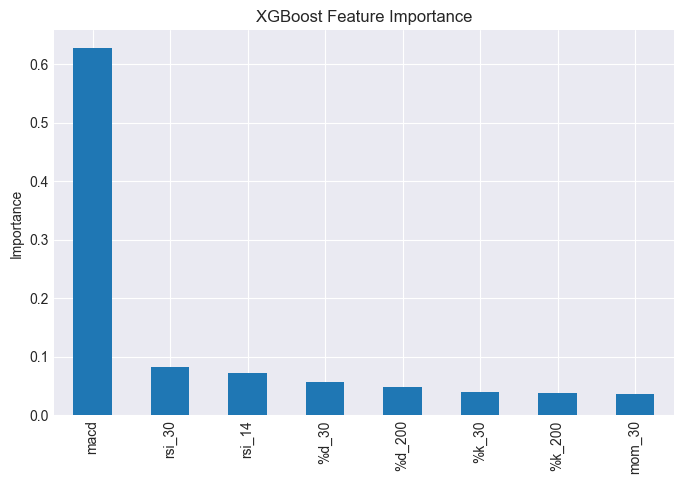

macd      0.626795
rsi_30    0.082979
rsi_14    0.072036
%d_30     0.056344
%d_200    0.048515
%k_30     0.040066
%k_200    0.037162
mom_30    0.036103
dtype: float32

In [59]:
# XGBoost feature importance

importance = pd.Series(
    xgb_best.feature_importances_,
    index=selected_features
).sort_values(ascending=False)

plt.figure(figsize=(8,5))
importance.plot(kind="bar")
plt.title("XGBoost Feature Importance")
plt.ylabel("Importance")
plt.show()

importance

In [60]:
# Logistic Regression Baseline

logreg = LogisticRegression(
    C=0.1,
    penalty="l1",
    solver="saga",
    max_iter=300
).fit(X_train_s[:, sel_idx], y_train)

logreg

,penalty,'l1'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,300
,multi_class,'deprecated'


In [61]:
# Evaluation

def evaluate(model, X, y):
    pred = model.predict(X)
    prob = model.predict_proba(X)[:,1]
    return {
        "accuracy": accuracy_score(y, pred),
        "precision": precision_score(y, pred),
        "recall": recall_score(y, pred),
        "f1": f1_score(y, pred),
        "roc_auc": roc_auc_score(y, prob)
    }

metrics_xgb = evaluate(xgb_best, X_test_s[:, sel_idx], y_test)
metrics_log = evaluate(logreg, X_test_s[:, sel_idx], y_test)

metrics_xgb, metrics_log


({'accuracy': 0.9196891191709845,
  'precision': 0.9358490566037736,
  'recall': 0.9465648854961832,
  'f1': 0.9411764705882353,
  'roc_auc': 0.9776840679635557},
 {'accuracy': 0.9196891191709845,
  'precision': 0.9391634980988594,
  'recall': 0.9427480916030534,
  'f1': 0.940952380952381,
  'roc_auc': 0.9793154395469095})

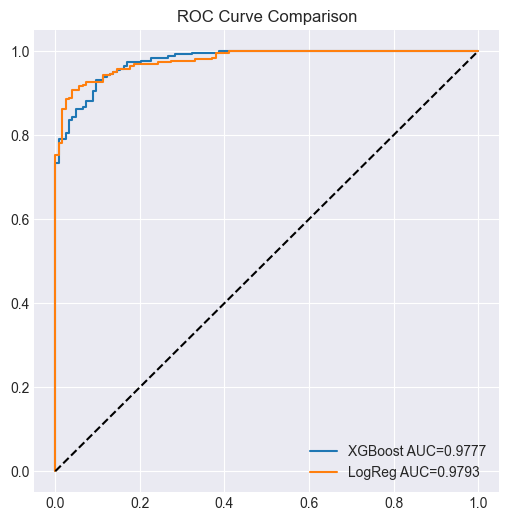

In [62]:
# ROC Curve Plotting

prob_x = xgb_best.predict_proba(X_test_s[:, sel_idx])[:,1]
prob_l = logreg.predict_proba(X_test_s[:, sel_idx])[:,1]

fpr_x, tpr_x, _ = roc_curve(y_test, prob_x)
fpr_l, tpr_l, _ = roc_curve(y_test, prob_l)

plt.figure(figsize=(6,6))
plt.plot(fpr_x, tpr_x, label=f"XGBoost AUC={metrics_xgb['roc_auc']:.4f}")
plt.plot(fpr_l, tpr_l, label=f"LogReg AUC={metrics_log['roc_auc']:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("ROC Curve Comparison")
plt.show()

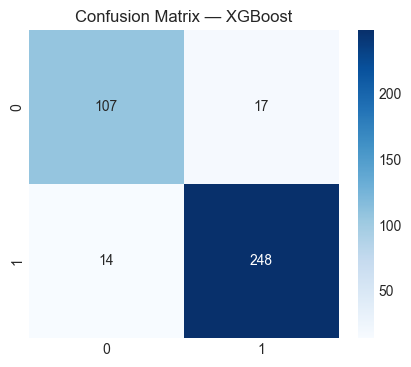

In [63]:
# Confusion Matrix Plotting

cm = confusion_matrix(y_test, xgb_best.predict(X_test_s[:, sel_idx]))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — XGBoost")
plt.show()

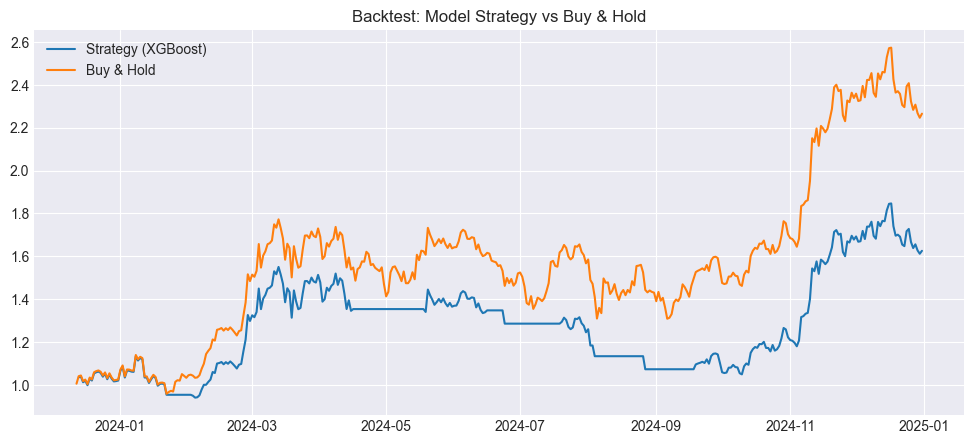

In [64]:
# Backtest (Daily Long Strategy)

signals = pd.Series(
    xgb_best.predict(X_test_s[:, sel_idx]),
    index=X_test.index
)

returns = df_lab["Close"].pct_change().loc[signals.index]

strategy = (1 + signals.shift(1) * returns).cumprod()
buyhold = (1 + returns).cumprod()

plt.figure(figsize=(12,5))
plt.plot(strategy, label="Strategy (XGBoost)")
plt.plot(buyhold, label="Buy & Hold")
plt.legend()
plt.title("Backtest: Model Strategy vs Buy & Hold")
plt.show()

## Error Analysis

The model makes two types of mistakes:

### **False Positives (Predict Buy but True Signal = Sell)**
Interpretation:
- The model detects momentum incorrectly  
- Usually happens before a trend reversal  

### **False Negatives (Predict Sell but True Signal = Buy)**
Interpretation:
- The model is conservative  
- Avoids taking early positions  
- Often enters trends late  

These behaviors are typical of trend-following systems and explain why
Buy & Hold sometimes outperforms in strong bull markets.

## Backtest Interpretation

The ML strategy behaves like a conservative trend-following system.

### Why Buy & Hold Outperforms at Times
- Buy & Hold participates fully in strong BTC bull runs  
- Trend models react only after indicators confirm the trend  

### Strengths of the ML Strategy
- Cuts losses during prolonged sideways/downward periods  
- Maintains steady growth with smaller drawdowns  
- Provides interpretable and stable signals  

The purpose of this model is *not* to beat Buy & Hold during a macro bull run,  
but to provide structured, lower-volatility participation in trends.


In [65]:
# Saving Artifacts

os.makedirs("artifacts", exist_ok=True)

joblib.dump(xgb_best, "artifacts/xgb_model.pkl")
joblib.dump(logreg, "artifacts/logreg_model.pkl")
joblib.dump(scaler, "artifacts/scaler.pkl")
joblib.dump(selected_features, "artifacts/selected_features.pkl")

print("Artifacts saved!")

Artifacts saved!
